# Complete evaluation of 3 algorithms on 3 networks

**Inputs:**
* Algorithms: bjointsp, random, greedy
* Network: Abilene, Airtel, Colt
* Service: fw1chain, fw2chain, fw3chain
* Sources: source0-9

![Abilene](http://topology-zoo.org/maps/Abilene.jpg)

Due to its small size, Abilene is the standard network for evaluating placement algorithms. 11 nodes, 14 edges.

![Airtel](http://topology-zoo.org/maps/Airtel.jpg)

Airtel is still quite small but has much larger distances, leading to higher link delays. Here, rounding delays to full integers (in ms) has a relatively smaller effect than in the other networks. 16 nodes, 37 edges.

![Colt](http://topology-zoo.org/maps/Colt.jpg)

Colt is much larger (more nodes and edges) but has many short edges with delays below 1 ms. Rounding affects these delays strongly and even leads to some link delays being set to 0 ms. 153 nodes, 191 edges.

In [17]:
%matplotlib inline
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# include and import util/eval.py
import os
import sys
module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path) 
from util import eval

In [18]:
# load all results into four dataframes (described below)
chain_df = pd.DataFrame()
aux_chain_df = pd.DataFrame()
vnf_df = pd.DataFrame()
aux_vnf_df = pd.DataFrame()

networks = ['Abilene', 'Airtel', 'Colt']
algorithms = ['bjointsp', 'greedy', 'random']
for net in networks:
    for alg in algorithms:
        chain, aux_chain, vnf, aux_vnf = eval.prepare_eval(net, alg)
        chain_df = pd.concat([chain_df, chain])
        aux_chain_df = pd.concat([aux_chain_df, aux_chain])
        vnf_df = pd.concat([vnf_df, vnf])
        aux_vnf_df = pd.concat([aux_vnf_df, aux_vnf])

There are four different pandas dataframes:

*chain_df* contains the delays (RTTs) of the whole chain and *vnf_df* contains the inter-VNF delays. They have separate columns for the simulation and emulation RTTs and additional columns for the difference and the ratio between simulation and emulation RTT.

For easier plotting later, *aux_chain_df* and *aux_vnf_df* contain the same data as *chain_df* and *vnf_df*, respectiveley, just in a different structure: Here, there is just one column called 'rtt'. Simulation and emulation delays are stored in the same column in different rows. They are distinguished by a new column 'type' that is either 'sim' or 'emu', classifying the type of RTT.

For better intuition, see the tables below.

In [4]:
chain_df.head()

,network,num_nodes,num_edges,service,num_vnfs,sources,num_sources,algorithm,sim_rtt,emu_rtt,rtt_diff,rtt_ratio
0,Abilene,11,14,fw1chain,3,source0,1,bjointsp,6.0,7.1,1.1,1.183333
1,Abilene,11,14,fw1chain,3,source1,1,bjointsp,6.0,7.1,1.1,1.183333
2,Abilene,11,14,fw1chain,3,source2,1,bjointsp,8.0,9.1,1.1,1.137500
3,Abilene,11,14,fw1chain,3,source3,1,bjointsp,8.0,9.1,1.1,1.137500
4,Abilene,11,14,fw1chain,3,source4,1,bjointsp,14.0,15.1,1.1,1.078571


In [5]:
aux_chain_df.head()

,algorithm,network,num_nodes,num_edges,service,num_vnfs,sources,num_sources,rtt,type
0,bjointsp,Abilene,11,14,fw1chain,3,source0,1,6.0,sim
1,bjointsp,Abilene,11,14,fw1chain,3,source1,1,6.0,sim
2,bjointsp,Abilene,11,14,fw1chain,3,source2,1,8.0,sim
3,bjointsp,Abilene,11,14,fw1chain,3,source3,1,8.0,sim
4,bjointsp,Abilene,11,14,fw1chain,3,source4,1,14.0,sim


In [6]:
vnf_df.head()

,network,num_nodes,num_edges,service,num_vnfs,sources,num_sources,algorithm,src,dest,sim_rtt,emu_rtt,rtt_diff,rtt_ratio
0,Abilene,11,14,fw1chain,3,source0,1,bjointsp,vnf_user,vnf_fw1,2.0,2.210,0.210,1.10500
1,Abilene,11,14,fw1chain,3,source0,1,bjointsp,vnf_fw1,vnf_web,4.0,4.238,0.238,1.05950
2,Abilene,11,14,fw1chain,3,source1,1,bjointsp,vnf_user,vnf_fw1,2.0,2.203,0.203,1.10150
3,Abilene,11,14,fw1chain,3,source1,1,bjointsp,vnf_fw1,vnf_web,4.0,4.223,0.223,1.05575
4,Abilene,11,14,fw1chain,3,source2,1,bjointsp,vnf_user,vnf_fw1,2.0,2.191,0.191,1.09550


## Chain RTT

Let's start the evaluation by analyzing the RTT of the whole chain, comparing the different placement algorithms and networks.

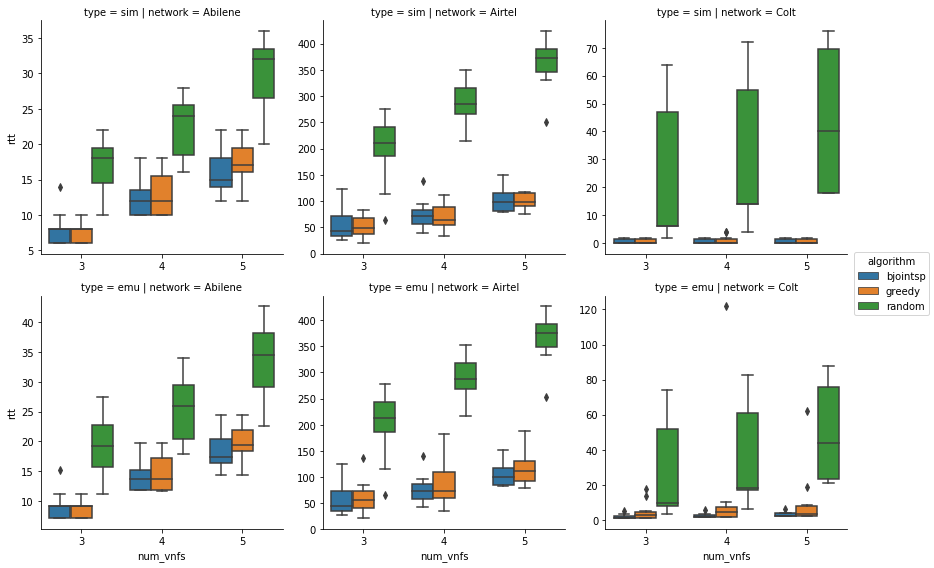

In [7]:
# compare chain RTT for the different algorithms (separately for sim/emu and the different networks)
g = sns.factorplot(x='num_vnfs', y='rtt', hue='algorithm', row='type', col='network', 
                   data=aux_chain_df, kind='box', sharey=False)

The plot shows all information about chain delays at once. Useful to get a first overview:

* for all networks and algorithms, the chain delay increases with chain length (not as visible in the Colt network)
* bjointsp and greedy have similar delays
* random placement leads to much higher delays
* it also has a higher delay spread - especially in the Colt network
* as expected, the delay in the US network Abilene are smallest, in the European network Colt second, and in the global network Airtel largest

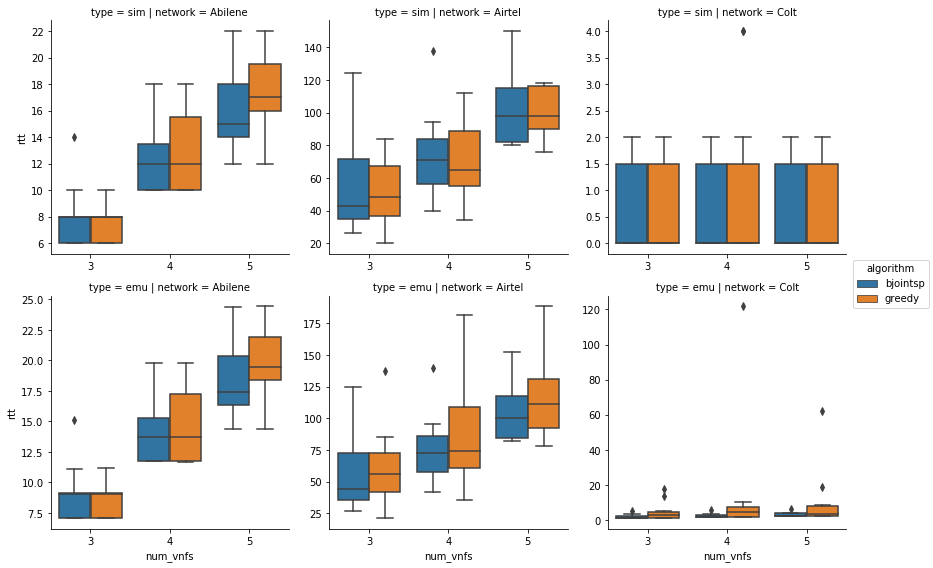

In [10]:
# same but only with bjointsp and greedy, not random
g = sns.factorplot(x='num_vnfs', y='rtt', hue='algorithm', row='type', col='network', 
                   data=aux_chain_df.loc[aux_chain_df['algorithm'] != 'random'], kind='box', sharey=False)

Now looking at only bjointsp and greedy since random is clearly worse anyways.
* bjointsp and greedy have rather similar delays. if not equal, bjointsp has shorter delays
  * not surprising since bjointsp's main strength are complex network services (bidirectional, stateful, ...) with joint scaling
  * through its iterative improvement bjointsp can overcome local optima and achieve better placements than plain greedy
* for Airtel with 4 VNFs, greedy actually has slightly shorter simulated delay than bjointsp (median). in emulation it is worse again
  * minimizing delay is only objective 4 of bjointsp after minimizing oversubscription, changes, resources
  * not sure why for this specific configuration and why only for simulation

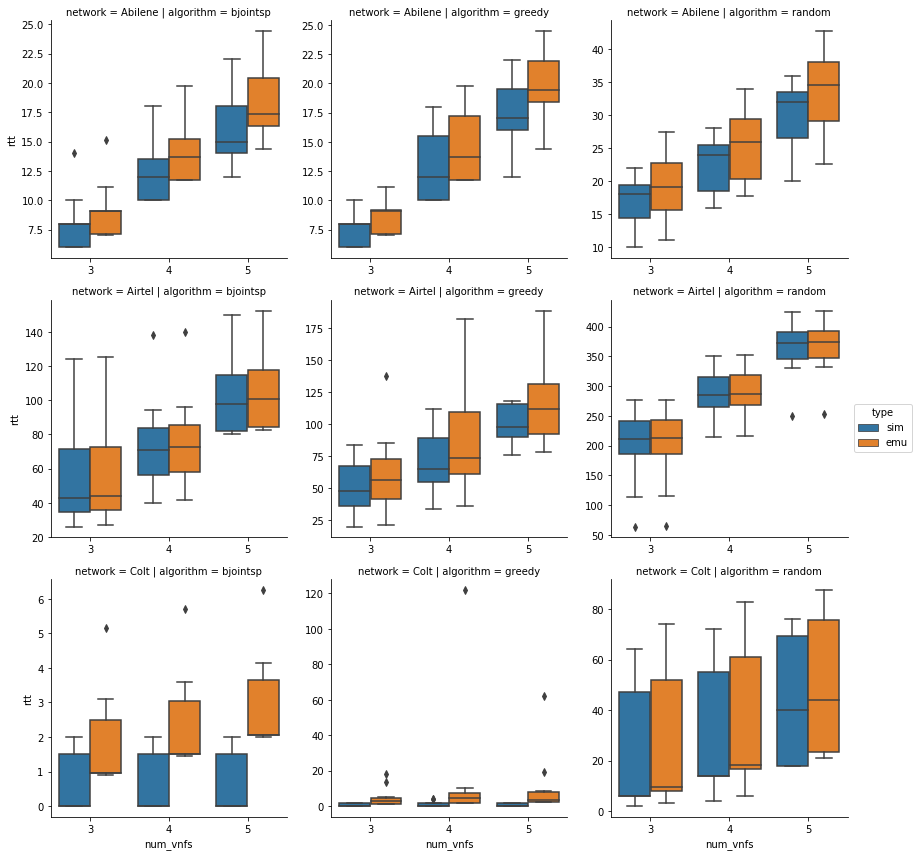

In [25]:
# compare simulated vs emulated delay (separately for each algorithm and network)
g = sns.factorplot(x='num_vnfs', y='rtt', hue='type', row='network', col='algorithm', 
                   data=aux_chain_df, kind='box', sharey=False)

Same data but focusing on the difference between simulated and emulated delay for each algorithm (column) and network (row).

* emulated delay is generally higher than simulated delay but usually not too much higher
* the Colt network is weird:
  * much higher delay difference for bjointsp (and greedy?)
  * extreme outliers of emulated delay for greedy
  * very broad spread of both simulated and emulated delay for random

### Chain RTT difference

Absolute difference between emulated and simulated chain RTT: emu_rtt - sim_rtt

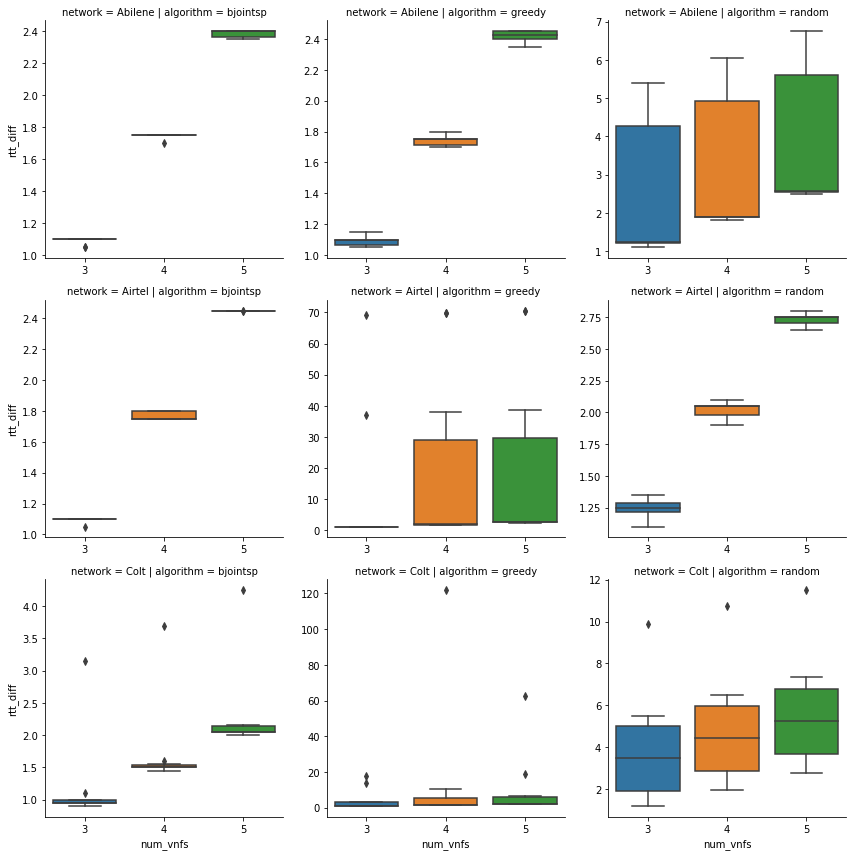

In [28]:
# chain RTT difference as function of the chain length (separate plots per network and algorithm)
g = sns.factorplot(x='num_vnfs', y='rtt_diff', col='algorithm', row='network', data=chain_df, kind='box', sharey=False)

When looking at the difference in RTT, the emulation delay is clearly higher than the simulation delay. And the difference between the two increases with increasing chain length. There is surprisingly little deviation in rtt_diff for each chain length.

While this observation holds for all algorithms and networks, there are significant differences:

* bjointsp has the smallest difference between sim RTT and emu RTT 
* there is almost no deviation in difference within each chain length (i.e., very clear steps of increased difference for increasing chain length/num_vnfs)
* this is similar for greedy on Abilene and random on Airtel. but:
  * random on Abilene, greedy on Airtel, random on Colt have a much higher spread in difference
  * greedy on Colt has some extreme outliers
  * why? how can this be explained?
  * rounding has a stronger effect on networks with short delays (especially Colt, also Abilene). why? rounded delays are used for both simulation and emulation, right?
  
**TODO: investigate rtt_diff as a function of sim_rtt**
  


### Chain RTT ratio

Relative ratio of emulated vs. simulated chain RTT: emu_rtt / sim_rtt

In [30]:
# set infinite ratios to NaN, so they are ignored when plotting
print('Entries with inifinite ratio: {}'.format(chain_df['rtt_ratio'].loc[chain_df['sim_rtt'] == 0].count()))

# per network
for net in networks:
    inf_rows = chain_df.loc[(chain_df['network'] == net) & (chain_df['sim_rtt'] == 0)]
    print('\t{} network: {}'.format(net, inf_rows['rtt_ratio'].count()))
    
    # per algorithm
    for alg in algorithms:
        inf_rows2 = inf_rows.loc[inf_rows['algorithm'] == alg]
        print('\t\t{}: {}'.format(alg, inf_rows2['rtt_ratio'].count()))
        
        
# total rows per network and algorithm. should be 10 (sources) * 3 (services) = 30
net_alg_rows = chain_df.loc[(chain_df['network'] == 'Abilene') & (chain_df['algorithm'] == 'bjointsp')]
print('\nTotal rows per network and algorithm: {}'.format(net_alg_rows.shape[0]))

# most simulated chain RTTs are 0 in the Colt network for bjointsp and greedy
# because many links there are very short and have <1ms delay => rounded to 0ms
# that's why the ratio plots below don't make sense for Colt (ratio is undefined for most values)

#vnf_df = vnf_df.replace(np.inf, np.nan)

Entries with inifinite ratio: 42
	Abilene network: 0
		bjointsp: 0
		greedy: 0
		random: 0
	Airtel network: 0
		bjointsp: 0
		greedy: 0
		random: 0
	Colt network: 42
		bjointsp: 21
		greedy: 21
		random: 0

Total rows per network and algorithm: 30


C:\ProgramData\Anaconda3\lib\site-packages\matplotlib\cbook\__init__.py:1831: RuntimeWarning: invalid value encountered in double_scalars
  stats['iqr'] = q3 - q1
C:\ProgramData\Anaconda3\lib\site-packages\matplotlib\cbook\__init__.py:1857: RuntimeWarning: invalid value encountered in less_equal
  wiskhi = np.compress(x <= hival, x)
C:\ProgramData\Anaconda3\lib\site-packages\matplotlib\cbook\__init__.py:1864: RuntimeWarning: invalid value encountered in greater_equal
  wisklo = np.compress(x >= loval, x)


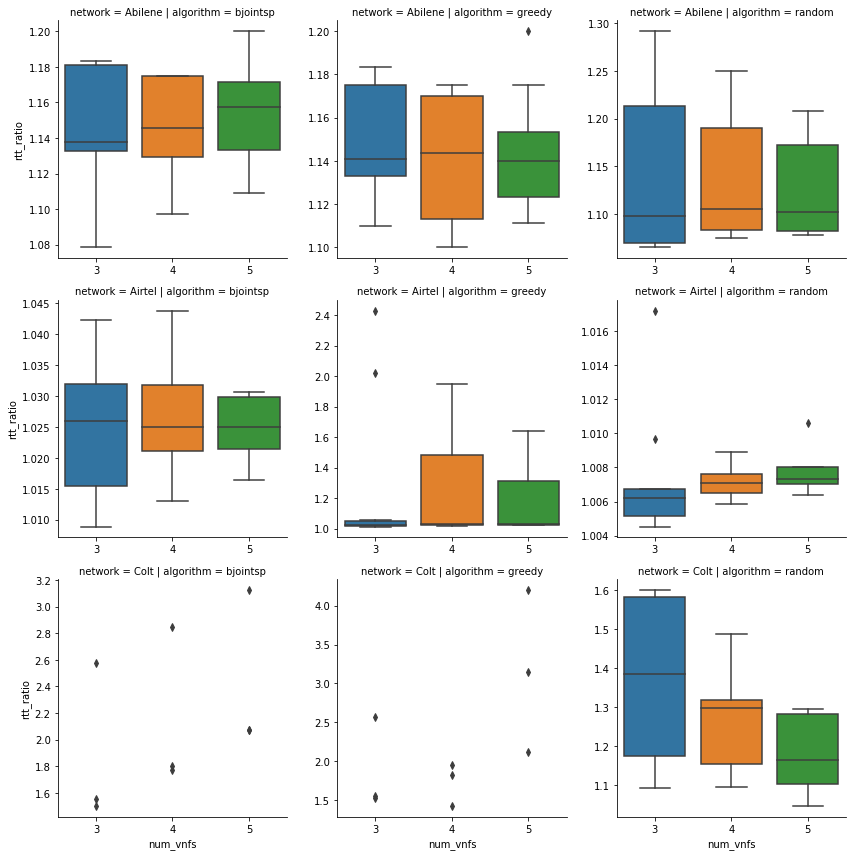

In [14]:
#sns.boxplot(x='num_vnfs', y='rtt_ratio', hue='algorithm', data=chain_df).set_title('Chain RTT ratio')

# chain RTT ratio as function of the chain length (separate plots per network and algorithm)
g = sns.factorplot(x='num_vnfs', y='rtt_ratio', col='algorithm', row='network', data=chain_df, kind='box', sharey=False)

**B-JointSP**: While the absolute difference between emulated and simulated chain RTT clearly increases for increasing chain length, the relative ratio of the two stays fairly constant at slightly above 1.
The spread is higher for chains with three VNFs than with four or five, probably due to the shorter sim_rtt (deviations affect the ratio stronger).

**Random**: While the RTT difference is higher, random placement actually has a lower ratio RTT ratio compared to B-JointSP. Also the spread is smaller. This is probably also due to the longer path lengths and higher overall delays, leading to lower ratios and less relative spread. Here, the ratio seems to increase very slightly with longer chains lengths.

## Inter-VNF RTT
Let's do the same for inter-VNF delays/RTTs. Now, we're looking at two VNFs in isolation, i.e., independent of the rest of the chain. Thus, we're not considering chain length.

Text(0.5,1,'Inter-VNF RTT')

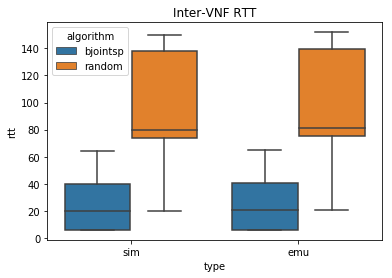

In [31]:
aux_vnf_df = pd.concat([bjointsp_aux_vnf_df, random_aux_vnf_df])

sns.boxplot(x='type', y='rtt', hue='algorithm', data=aux_vnf_df).set_title('Inter-VNF RTT')

As expected, random placement also leads to much higher inter-VNF delays than bjointsp. 
The difference between simulation and emulation delays seems to be negligible when considering inter-VNF RTTs. Let's look into that further.

### Inter-VNF RTT difference

Absolute difference between emulated and simulated inter-VNF RTT: emu_rtt - sim_rtt

Text(0.5,1,'Inter-VNF RTT difference')

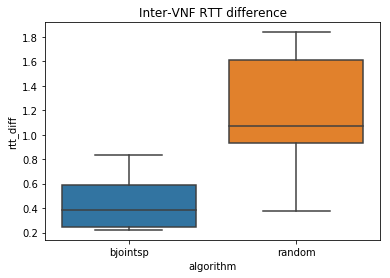

In [32]:
vnf_df = pd.concat([bjointsp_vnf_df, random_vnf_df])

sns.boxplot(x='algorithm', y='rtt_diff', data=vnf_df).set_title('Inter-VNF RTT difference')

The absolute difference between simulated and emulated inter-VNF RTTs is rather small. 

For bjointsp, it is generally smaller (< 1ms) than for random placement. Also the spread is smaller for bjointsp. This is probably due to the longer paths in random placement, which allow for more deviation between simulation and emulation. (Similar to the observation for chain RTTs.)

Compared to chain RTTs: 
The simulation-emulation difference for chain RTTs was mainly influenced by the chain length. Longer chains lead to a higher difference between simulated and emulated chain RTT. For a given chain length, the spread is very low, i.e., all placements have a very similar chain RTT difference per chain length.

For inter-VNF RTTs, there is a significant spread of the inter-VNF RTT difference (emulation vs simulation). Both for bjointsp and random. Where does this spread come from?

Text(0.5,1,'Random inter-VNF RTT difference')

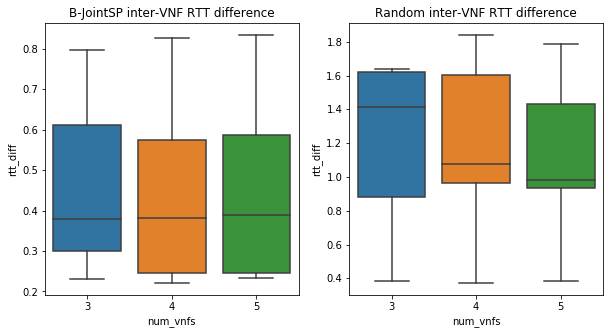

In [33]:
# plot RTT difference for different chain lengths
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 5))
sns.boxplot(x='num_vnfs', y='rtt_diff', data=bjointsp_vnf_df, ax=ax1).set_title('B-JointSP inter-VNF RTT difference')
sns.boxplot(x='num_vnfs', y='rtt_diff', data=random_vnf_df, ax=ax2).set_title('Random inter-VNF RTT difference')

Other than for chain RTTs, the chain length does not affect the inter-VNF RTT and cannot explain the large spread in inter-VNF RTT difference.

Text(0.5,1,'Random placement')

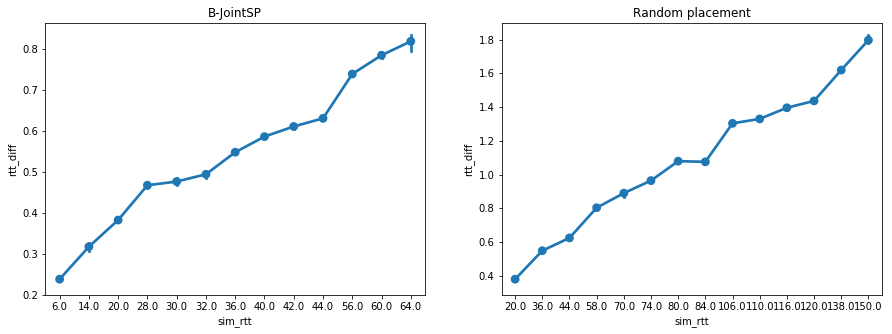

In [34]:
# plot RTT difference as a variable of the node distance = link delay = sim delay/RTT
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))
sns.pointplot(x='sim_rtt', y='rtt_diff', data=bjointsp_vnf_df, ax=ax1).set_title('B-JointSP')
sns.pointplot(x='sim_rtt', y='rtt_diff', data=random_vnf_df, ax=ax2).set_title('Random placement')

The difference of emulated and simulated inter-VNF RTTs increases with increasing simulated inter-VNF RTT. The simulated inter-VNF RTT directly reflects the link delay and thus distance between two connected VNFs.

Hence, for two very close VNFs, the simulated and emulated delays are almost identical, but for VNFs that are placed farther away (higher sim_rtt), the emulated delay can be significantly larger than the simulated delay.

This holds for both placement algorithms.


### Inter-VNF RTT ratio

Relative ratio of emulated vs. simulated inter-VNF RTT: emu_rtt / sim_rtt

Set to infinity if sim_rtt = 0.

In [35]:
# set infinite ratios to NaN, so they are ignored when plotting
print('Entries with inifinite ratio: {}'.format(vnf_df['rtt_ratio'].loc[vnf_df['rtt_ratio'] == np.inf].count()))
vnf_df = vnf_df.replace(np.inf, np.nan)

Entries with inifinite ratio: 0


Text(0.5,1,'Inter-VNF RTT ratio')

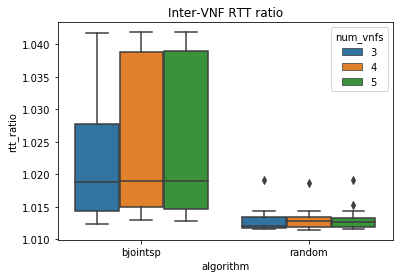

In [36]:
sns.boxplot(x='algorithm', y='rtt_ratio', hue='num_vnfs', data=vnf_df).set_title('Inter-VNF RTT ratio')

Similar to the chain RTT ratio, the inter-VNF RTT ratio is pretty much constant with increasing chain length and very close to 1.

While very close to 1 for both algorithms, bjoint sp has slightly higher ratios with significantly higher spread than random placement. This is likely due to the overall longer paths between VNFs in random placment, which lead to a lower relative ratio between emulated and simulated delay.

# Conclusion

Nothing too surprising:

* Random placement leads to much higher delays than B-JointSP
* For both algorithms, the chain RTT clearly increases with increasing chain length
* For longer chains, also the absolute difference of simulated vs emulated chain RTT increases
* The inter-VNF RTT and RTT difference (simulation vs emulation) are mostly influenced by the distance of the two connected VNFs
* In general, higher distance/chain length leads to higher absolute difference between simulation and emulation RTT but lower relative ratio of emulation and simulation RTT.